In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Directories
BASE_DIR = Path(".")
DATA_DIR = BASE_DIR / "BODMAS"
PROCESSED_DIR = BASE_DIR / "processed"
PROCESSED_DIR.mkdir(exist_ok=True)

print("Directories ready.")
print(f"DATA_DIR: {DATA_DIR.resolve()}")
print(f"PROCESSED_DIR: {PROCESSED_DIR.resolve()}")

# Load datasets
metadata_df = pd.read_csv(DATA_DIR / "bodmas_metadata.csv")
labels_df = pd.read_csv(DATA_DIR / "bodmas_malware_category.csv")
npz_file = np.load(DATA_DIR / "bodmas.npz")
features = npz_file['X']  # correct key

print("Raw data loaded.")
print("Metadata shape:", metadata_df.shape)
print("Labels shape:", labels_df.shape)
print("Features shape:", features.shape)

# Merge metadata and labels on sha256
merge_col = 'sha' if 'sha' in metadata_df.columns else 'sha256'
if merge_col in metadata_df.columns and 'sha256' in labels_df.columns:
    full_metadata_df = pd.merge(metadata_df, labels_df, left_on=merge_col, right_on='sha256')
else:
    min_len = min(len(metadata_df), len(labels_df))
    full_metadata_df = pd.concat([
        metadata_df.iloc[:min_len].reset_index(drop=True),
        labels_df.iloc[:min_len].reset_index(drop=True)
    ], axis=1)

Directories ready.
DATA_DIR: C:\Research Projects\research_projects_bundle\Malware_Classification_Project\new_malware\BODMAS
PROCESSED_DIR: C:\Research Projects\research_projects_bundle\Malware_Classification_Project\new_malware\processed
Raw data loaded.
Metadata shape: (134435, 3)
Labels shape: (57293, 2)
Features shape: (134435, 2381)


In [21]:
# Align features
min_rows = min(features.shape[0], len(full_metadata_df))
features = features[:min_rows]
full_metadata_df = full_metadata_df.iloc[:min_rows]

# Build features DataFrame
feature_cols = [f"feature_{i}" for i in range(features.shape[1])]
features_df = pd.DataFrame(features, columns=feature_cols)

# Combine metadata and features
df = pd.concat([full_metadata_df.reset_index(drop=True), features_df], axis=1)
print("Data merged. Final shape:", df.shape)

# Save processed dataset
output_pkl = PROCESSED_DIR / "clean_bodmas.pkl"
output_csv = PROCESSED_DIR / "clean_bodmas.csv"
df.to_pickle(output_pkl)
df.to_csv(output_csv, index=False)
print(f"Saved processed dataset to:\n- {output_pkl}\n- {output_csv}")

Data merged. Final shape: (57293, 2386)
Saved processed dataset to:
- processed\clean_bodmas.pkl
- processed\clean_bodmas.csv


In [22]:
# Identify malware category column
malware_col = next(
    (col for col in ['category', 'malware_category', 'MalwareCategory'] if col in df.columns),
    None
)
if malware_col is None:
    raise KeyError("No malware category column found.")
print(f"Malware column identified: {malware_col}")

Malware column identified: category


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25652\3471869889.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


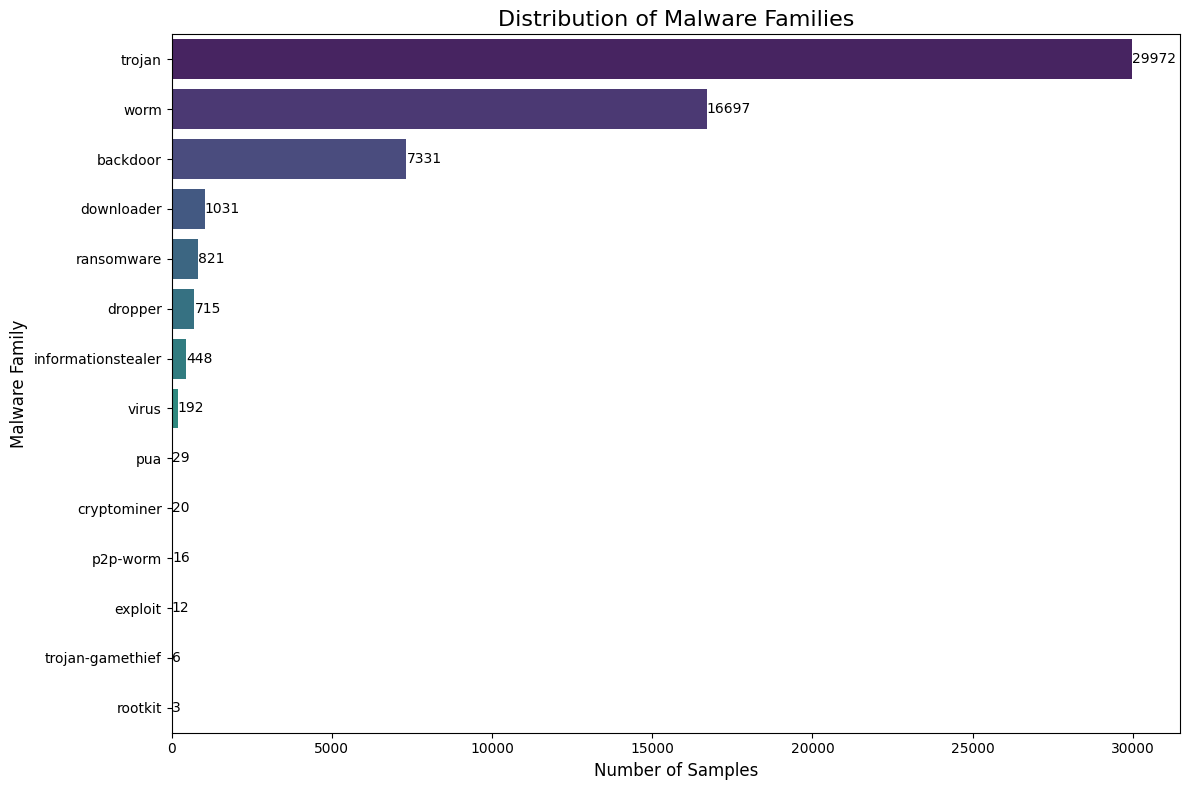

In [23]:
# Distribution plot
plt.figure(figsize=(12, 8))
ax = sns.countplot(
    y=df[malware_col],
    order=df[malware_col].value_counts().index,
    palette='viridis'
)
plt.title('Distribution of Malware Families', fontsize=16)
plt.xlabel('Number of Samples', fontsize=12)
plt.ylabel('Malware Family', fontsize=12)
for container in ax.containers:
    ax.bar_label(container)
plt.tight_layout()
plt.show()

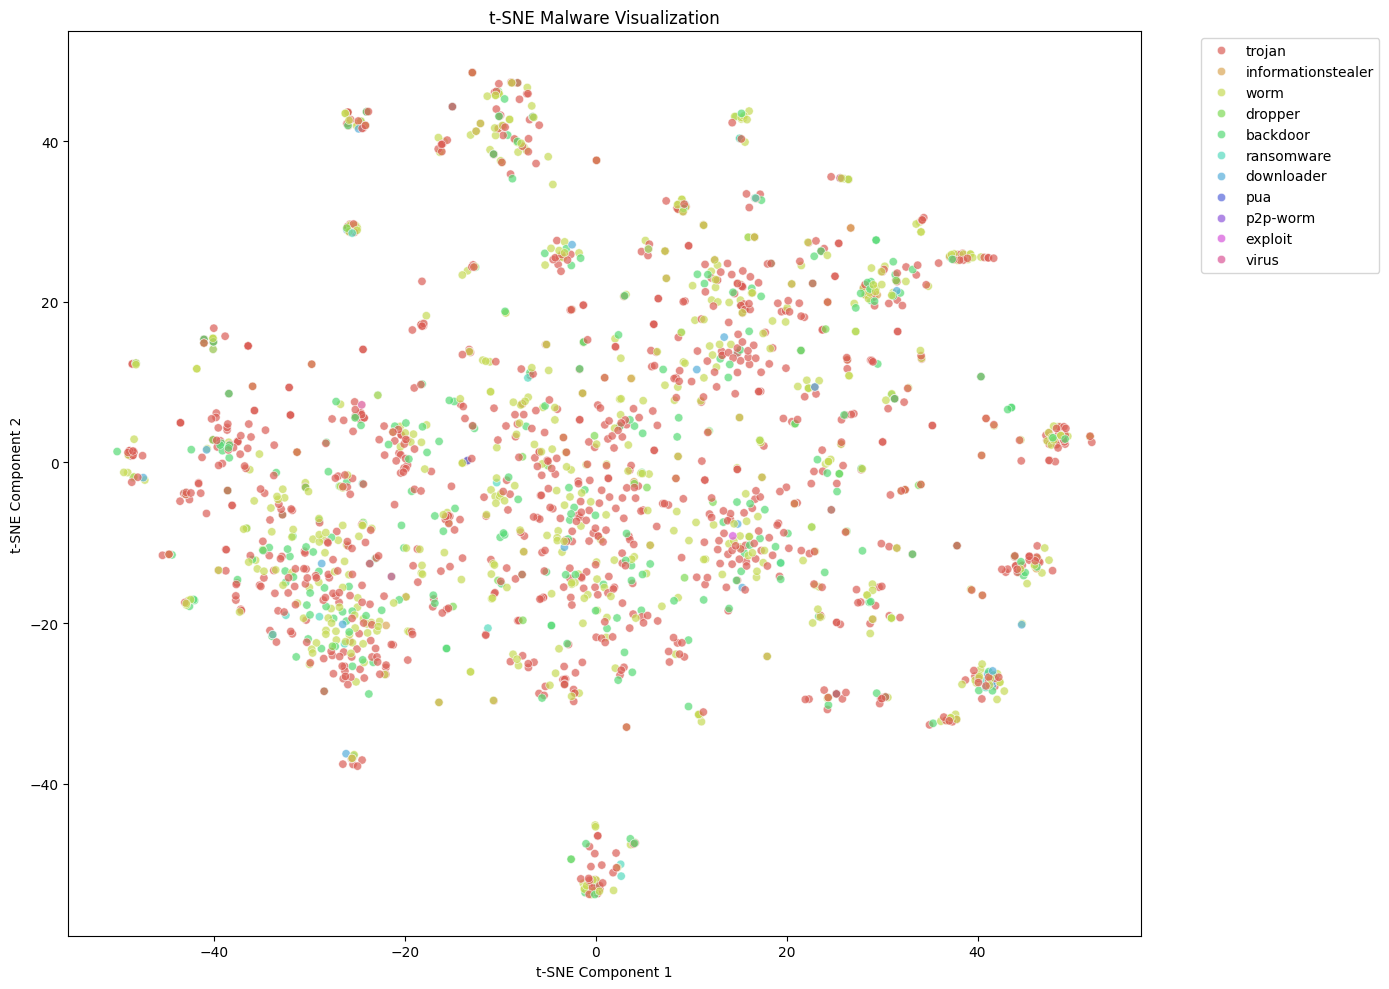

In [24]:
# t-SNE visualization
tsne_sample_size = 2000
df_tsne = df.sample(n=min(tsne_sample_size, len(df)), random_state=42)
feature_cols = [col for col in df_tsne.columns if 'feature_' in col]
X_tsne = df_tsne[feature_cols]
y_tsne = df_tsne[malware_col]

# Scale features
X_scaled = StandardScaler().fit_transform(X_tsne)
# TSNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
tsne_results = tsne.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(14, 10))
sns.scatterplot(
    x=tsne_results[:, 0],
    y=tsne_results[:, 1],
    hue=y_tsne,
    palette=sns.color_palette("hls", n_colors=len(y_tsne.unique())),
    legend="full",
    alpha=0.7
)
plt.title('t-SNE Malware Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.tight_layout()
plt.show()